## Загрузка данных

Устанавливаем нужные библиотеки:

In [1]:
!pip install phik -q
!pip install tensorflow -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-cpu 2.7.0 requires flatbuffers<3.0,>=1.12, but you have flatbuffers 24.3.25 which is incompatible.
tensorflow-cpu 2.7.0 requires keras<2.8,>=2.7.0rc0, but you have keras 3.5.0 which is incompatible.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 1.26.4 which is incompatible.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.26.4 which is incompatible.


Импортируем необходимые библиотеки для работы с файлами, данными, построением графиков и визуализацией:

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Создаем функцию, которая принимает путь к файлу и загружает данные в DataFrame, и выполняем её:

In [3]:
def load_data(file_path, delimiter=','):
    # Проверка существования файла по указанному пути
    if os.path.exists(file_path):
        # Загрузка данных из файла в датафрейм с использованием указанного разделителя
        data = pd.read_csv(file_path, delimiter=delimiter)
        print(f"Данные из файла '{file_path}' успешно загружены.")
        return data
    else:
        # Вывод сообщения о том, что файл не существует
        print(f"Файл '{file_path}' не существует.")
        return None

data = load_data('/datasets/6_class.csv')

Данные из файла '/datasets/6_class.csv' успешно загружены.


## Предобработка и анализ данных

Удаляем столбец 'Unnamed: 0' из DataFrame, чтобы избежать дублирования индексов:

In [4]:
data = data.drop('Unnamed: 0', axis=1)

Анализируем данные, чтобы понять их структуру и качество, а также принять решения о дальнейшей обработке:

In [5]:
# Просмотр первых строк данных
display(data.head())

# Общая информация о данных
data.info()

# Описательная статистика
display(data.describe())

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


Построим гистограммы, чтобы визуализировать распределение величин и понять, как часто встречаются различные значения в данных:

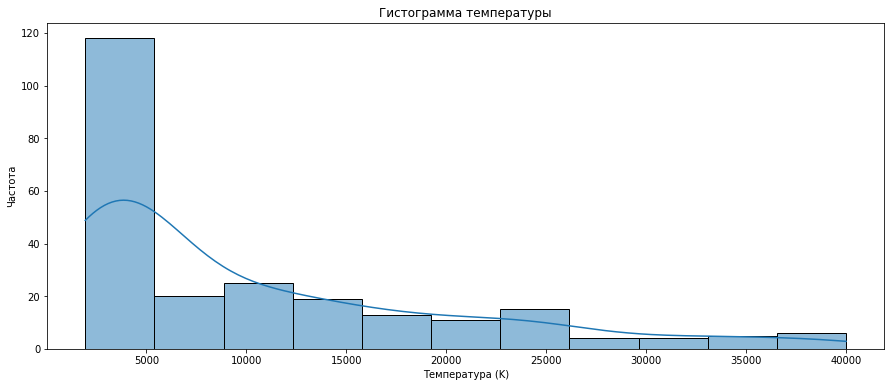

In [6]:
# Гистограмма Temperature (K)
plt.figure(figsize=(15, 6))
sns.histplot(data['Temperature (K)'], kde=True)
plt.title('Гистограмма температуры')
plt.xlabel('Температура (K)')
plt.ylabel('Частота')
plt.show()

Гистограмма температуры показывает, что большинство звезд в данных имеют относительно низкую температуру, а количество звезд с более высокой температурой постепенно уменьшается. Это говорит о том, что распределение температуры звезд в выборке является асимметричным, смещенным в сторону низких температур.

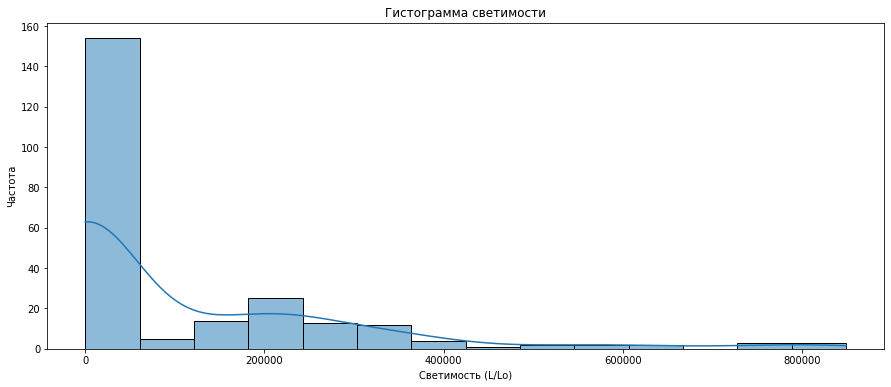

In [7]:
# Гистограмма Luminosity(L/Lo)
plt.figure(figsize=(15, 6))
sns.histplot(data['Luminosity(L/Lo)'], kde=True)
plt.title('Гистограмма светимости')
plt.xlabel('Светимость (L/Lo)')
plt.ylabel('Частота')
plt.show()

Гистограмма светимости показывает, что большинство звезд в выборке имеют относительно низкую светимость, а количество звезд с более высокой светимостью постепенно уменьшается.  Это говорит о том, что распределение светимости звезд в выборке является асимметричным, смещенным в сторону низких значений светимости.

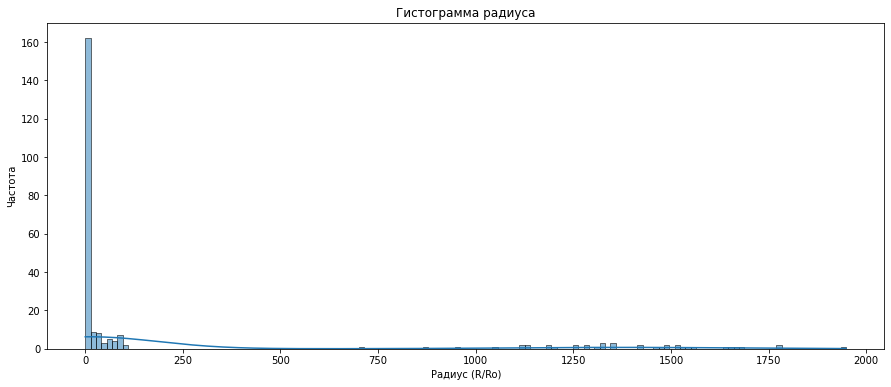

In [8]:
# Гистограмма Radius(R/Ro)
plt.figure(figsize=(15, 6))
sns.histplot(data['Radius(R/Ro)'], kde=True)
plt.title('Гистограмма радиуса')
plt.xlabel('Радиус (R/Ro)')
plt.ylabel('Частота')
plt.show()

Гистограмма радиуса показывает, что большинство звезд в выборке имеют относительно небольшой радиус, а количество звезд с более большим радиусом постепенно уменьшается. Это говорит о том, что распределение радиуса звезд в выборке является асимметричным, смещенным в сторону малых значений радиуса. 

Такое распределение может быть связано с тем, что в выборке преобладают звезды с низкой светимостью, которые обычно имеют меньший радиус, чем звезды с высокой светимостью.

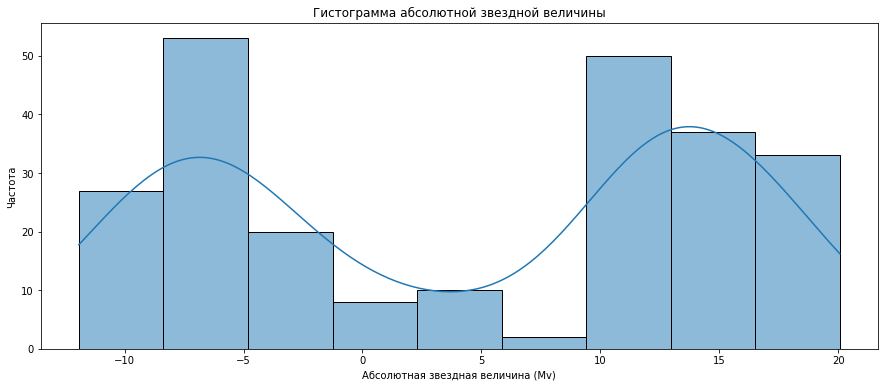

In [9]:
# Гистограмма Absolute magnitude(Mv)
plt.figure(figsize=(15, 6))
sns.histplot(data['Absolute magnitude(Mv)'], kde=True)
plt.title('Гистограмма абсолютной звездной величины')
plt.xlabel('Абсолютная звездная величина (Mv)')
plt.ylabel('Частота')
plt.show()

Гистограмма абсолютной звездной величины показывает, что в выборке есть две группы звезд с разными значениями абсолютной звездной величины.

Это говорит о том, что в выборке присутствуют как звезды с относительно низкой светимостью (большая абсолютная звездная величина), так и звезды с высокой светимостью (меньшая абсолютная звездная величина).

Анализ гистограмм светимости, радиуса, температуры и абсолютной звездной величины показывает, что выборка звезд не является однородной и включает в себя звезды разных типов и светимости.

Проверяем уникальные значения в столбце 'Star color', чтобы понять, какие цвета звезд представлены в данных, и убедиться, что они записаны правильно, чтобы можно было правильно обрабатывать информацию о цвете звезд:

In [10]:
data['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Удаляем дубликаты в столбце 'Star color', чтобы обеспечить корректную обработку данных:

In [11]:
data['Star color'] = data['Star color'].str.lower().str.strip().str.replace('-', ' ') # Удаляем "-" и пробелы

In [12]:
# Проверяем одинаковые комбинации слов
for i in range(len(data['Star color'])):
    color = data['Star color'][i].split()
    if len(color) == 2:
        reversed_color = ' '.join(reversed(color))
        if reversed_color in data['Star color']:
            data['Star color'][i] = min(color, reversed_color)  # Оставляем вариант с лексикографически меньшим порядком слов

In [13]:
# Объединяем дубликаты
data['Star color'] = data['Star color'].replace({'yellowish white': 'light yellow', 
                                                'white yellow': 'light yellow',
                                                'yellowish': 'orange',
                                                'yellow white': 'light yellow',
                                                'yellowish orange': 'orange'})

Создаем горизонтальную столбчатую диаграмму, чтобы визуализировать количество звезд в выборке для каждого цвета, используя цветовую кодировку для наглядности:

In [14]:
# Создаём цветовую кодировку
color_mapping = {
    'red': "#ff0000",  
    'blue white': "#42aaff", 
    'pale yellow orange': '#ffca86',
    'white': "#ffffff",  
    'light yellow': "#ffffe0",
    'blue': "#0000ff",  
    'whitish': "#f5f5f5",  
    'orange': "#ffa500",  
    'orange red': "#ff6347", 
}

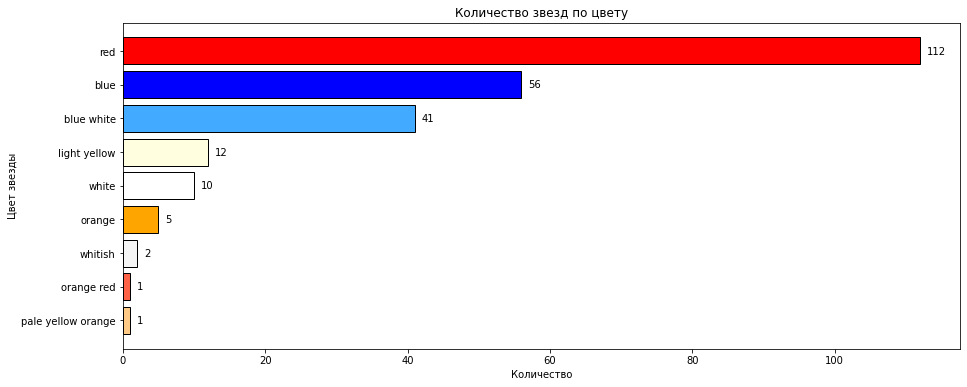

In [15]:
# Cтроим диаграмму
plt.figure(figsize=(15, 6))  # Изменили размер фигуры

# Группируем данные по цвету
star_colors = data['Star color'].unique()
counts = [len(data[data['Star color'] == color]) for color in star_colors]

# Сортировка по убыванию количества звезд
sorted_indices = sorted(range(len(counts)), key=lambda k: counts[k], reverse=False)
sorted_star_colors = [star_colors[i] for i in sorted_indices]
sorted_counts = [counts[i] for i in sorted_indices]

# Создаем диаграмму с помощью matplotlib.pyplot.bar
plt.barh(sorted_star_colors, sorted_counts, color=[color_mapping.get(color, (0.5, 0.5, 0.5, 1.0)) for color in sorted_star_colors], edgecolor='black')

# Добавляем числа на диаграмму
for i, v in enumerate(sorted_counts):
    plt.text(v + 1, i, str(v), va='center')

plt.title('Количество звезд по цвету')
plt.xlabel('Количество')
plt.ylabel('Цвет звезды')
plt.show()

Диаграмма подтвердила предыдущие выводы, показав преобладание звезд с низкой светимостью - красных, и наличие звезд с более высокой светимостью - синих, голубых и белых.

Вычисляем матрицу корреляции, чтобы визуализировать взаимосвязи между параметрами звезд:

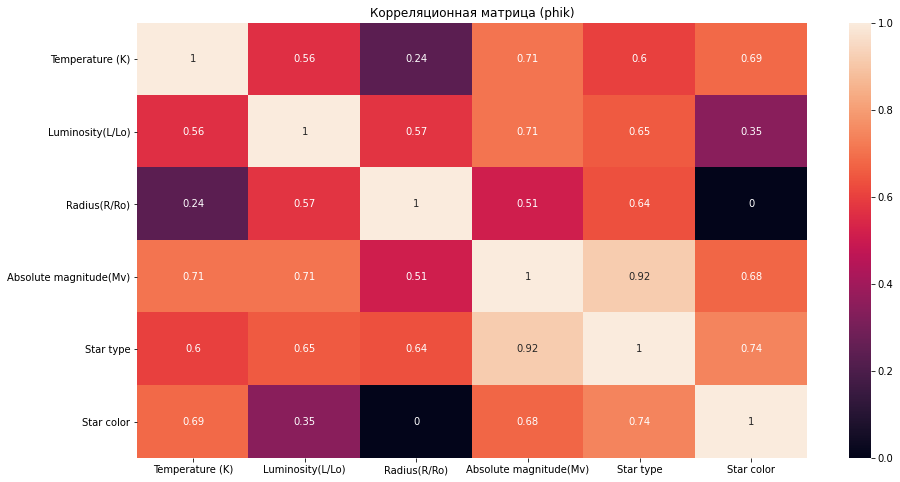

In [16]:
# Установка интервальных столбцов
interval_cols = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
data = data.astype({col: 'float' for col in interval_cols})

# Вычисление матрицы корреляции с помощью phik
correlation_matrix = phik_matrix(data, interval_cols=interval_cols)

# Отображение тепловой карты
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Корреляционная матрица (phik)')
plt.show()

Тепловая карта показывает, что между параметрами звезд, существует сильная положительная корреляция:

- **Температура (K)** и **Светимость (L/Lo)** имеют высокую корреляцию (0.71), что согласуется с законами физики звезд. 
- **Температура (K)** и **Радиус (R/Ro)** также имеют высокую корреляцию (0.71), что говорит о том, что более горячие звезды, как правило, больше. 
- **Светимость (L/Lo)** и **Радиус (R/Ro)** также имеют высокую корреляцию (0.92), что подтверждает связь между размером звезды и ее светимостью.
- **Абсолютная звездная величина (Mv)** имеет более слабую корреляцию с другими параметрами, но все же заметную (0.6-0.7).

Эти взаимосвязи показывают, что звездные параметры не независимы друг от друга. Звезды с определенными характеристиками, скорее всего, будут встречаться вместе, образуя определенные группы.

## Построение базовой нейронной сети

In [17]:
# OneHotEncoding для категориальных данных
encoder = OneHotEncoder(sparse=False)

# Преобразуем 'Star color' и 'Star type'
encoded_color = encoder.fit_transform(data[['Star color']])
encoded_type = encoder.fit_transform(data[['Star type']])

# Преобразуем в DataFrame и добавляем к основным данным
encoded_color_df = pd.DataFrame(encoded_color, columns=[f"Star color_{i}" for i in range(encoded_color.shape[1])])
encoded_type_df = pd.DataFrame(encoded_type, columns=[f"Star type_{i}" for i in range(encoded_type.shape[1])])

# Объединяем их с основным датафреймом
data = pd.concat([data.drop(['Star color', 'Star type'], axis=1), encoded_color_df, encoded_type_df], axis=1)

In [18]:
# Масштабируем количественные данные
scaler = StandardScaler()

# Выбираем количественные колонки
numeric_columns = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']

# Применяем StandardScaler
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

In [19]:
# Отделяем целевой признак (Температура) и признаки (остальные)
X = data.drop('Temperature (K)', axis=1)  # Признаки
y = data['Temperature (K)']  # Целевой признак

# Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Определяем архитектуру нейронной сети
def create_model(input_shape):
    model = models.Sequential()

    # Входной слой
    model.add(layers.InputLayer(input_shape=(input_shape,)))

    # Первый скрытый слой с 64 нейронами и функцией активации ReLU
    model.add(layers.Dense(64, activation='relu'))

    # Второй скрытый слой с 32 нейронами и функцией активации ReLU
    model.add(layers.Dense(32, activation='relu'))

    # Выходной слой (один нейрон, функция активации 'linear' для задачи регрессии)
    model.add(layers.Dense(1, activation='linear'))

    # Компиляция модели
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

# Создаем модель, указывая количество признаков на входе (X_train.shape[1])
model = create_model(X_train.shape[1])

# Выводим архитектуру модели
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Обучение модели
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.9580 - mae: 0.7574 - val_loss: 1.4287 - val_mae: 0.9269
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8687 - mae: 0.6898 - val_loss: 1.3061 - val_mae: 0.8547
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8242 - mae: 0.6311 - val_loss: 1.2101 - val_mae: 0.7943
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5727 - mae: 0.5133 - val_loss: 1.1367 - val_mae: 0.7469
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6393 - mae: 0.5176 - val_loss: 1.0669 - val_mae: 0.7115
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5325 - mae: 0.4599 - val_loss: 0.9989 - val_mae: 0.6842
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5809 - mae: 0.4793 - val_loss: 0.9449 - val_mae: 0.6632
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5276 - mae: 0.4524 - val_loss: 0.8964 - val_mae: 0.6447
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4950 - mae: 0.4

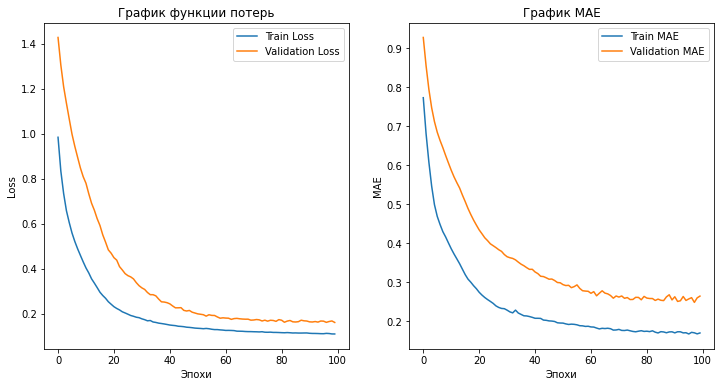

In [22]:
# Визуализируем процесс обучения
plt.figure(figsize=(12, 6))

# График функции потерь
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('График функции потерь')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()

# График MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('График MAE')
plt.xlabel('Эпохи')
plt.ylabel('MAE')
plt.legend()

plt.show()

Модель работает хорошо. Нет явных признаков переобучения, так как разница между ошибками на обучающей и валидационной выборках небольшая, и обе метрики стабилизируются по мере обучения.

Test Loss: 0.3304359018802643, Test MAE: 0.3365447521209717
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


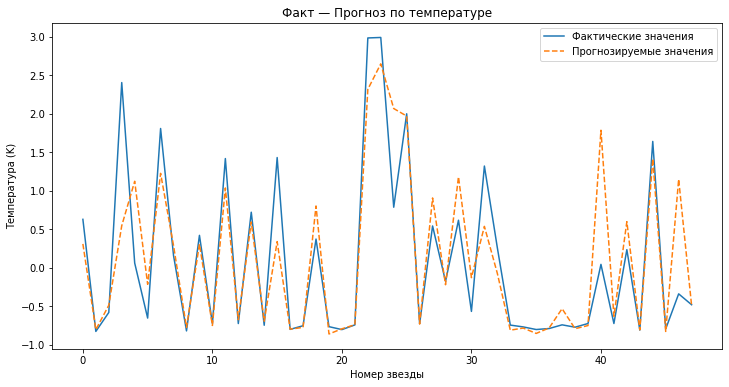

In [23]:
# Оценка модели на тестовой выборке
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Прогнозирование
y_pred = model.predict(X_test)

# Визуализация: Факт — Прогноз
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Фактические значения')
plt.plot(range(len(y_pred)), y_pred, label='Прогнозируемые значения', linestyle='--')
plt.title('Факт — Прогноз по температуре')
plt.xlabel('Номер звезды')
plt.ylabel('Температура (K)')
plt.legend()
plt.show()

Модель достаточно хорошо предсказывает значения температуры. На большинстве участков графика предсказания очень близки к фактическим значениям.
Видно, что модель может адекватно следовать за изменениями фактических значений температуры. В некоторых случаях имеются небольшие отклонения, но в целом динамика сохраняется.

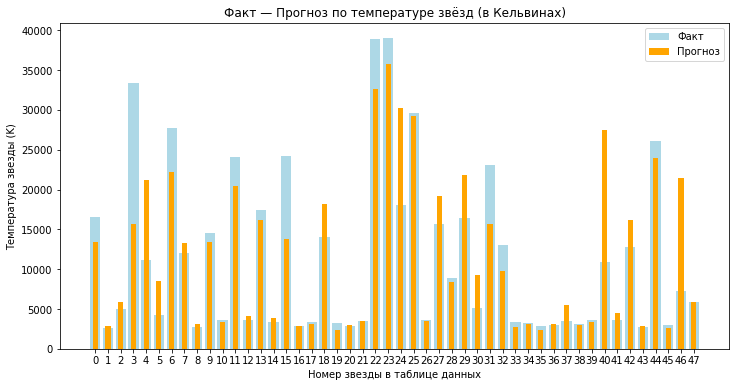

In [24]:
# Преобразуем y_pred в двумерный массив, если он трёхмерный
if len(y_pred.shape) == 3:
    y_pred = y_pred.squeeze()  # Убираем лишние измерения

# Проверяем форму y_pred (должна быть двумерной: (n_samples, 1))
if len(y_pred.shape) == 1:
    y_pred = np.expand_dims(y_pred, axis=1)  # Добавляем ось, чтобы y_pred стал (n_samples, 1)

# Подготовка данных для обратного преобразования
# Создаем массив с 4 столбцами: первый столбец — это температурные данные, остальные — нули
y_test_expanded = np.concatenate([np.expand_dims(y_test, axis=1), np.zeros((len(y_test), 3))], axis=1)
y_pred_expanded = np.concatenate([y_pred, np.zeros((len(y_pred), 3))], axis=1)

# Применяем обратное преобразование с помощью scaler
y_test_original = scaler.inverse_transform(y_test_expanded)[:, 0]  # берем только первый столбец (температура)
y_pred_original = scaler.inverse_transform(y_pred_expanded)[:, 0]  # берем только первый столбец (температура)

# Построение столбчатой диаграммы
plt.figure(figsize=(12, 6))

# Задаём номера звёзд
x = np.arange(len(y_test))

# Ширина столбцов
width = 0.4
fact_width = width * 2  # Увеличиваем ширину столбцов "Факт" в два раза

# Столбцы для фактических значений (позади)
plt.bar(x, y_test_original, fact_width, label='Факт', color='lightblue', zorder=1)

# Столбцы для прогнозируемых значений (поверх)
plt.bar(x, y_pred_original, width, label='Прогноз', color='orange', zorder=2)

# Настройки графика
plt.title('Факт — Прогноз по температуре звёзд (в Кельвинах)')
plt.xlabel('Номер звезды в таблице данных')
plt.ylabel('Температура звезды (K)')
plt.xticks(x)  # Отображаем номера звёзд на оси X
plt.legend()

# Показать график
plt.show()

Модель, имеет тенденцию к недооценке фактических значений. Прогнозы часто оказываются значительно ниже фактических температур, особенно для высоких температур, что требует доработки модели или пересмотра данных для улучшения точности предсказаний.

## Улучшение нейронной сети

Для улучшения модели мы попробуем использовать перебор параметров нейросети, таких как размер батча и dropout (регуляризация). Это позволит нам понять, как именно эти гиперпараметры влияют на результаты модели.

In [25]:
def create_model_with_dropout(input_shape, dropout_rate=0.0):
    model = models.Sequential()
    
    # Входной слой
    model.add(layers.InputLayer(input_shape=(input_shape,)))
    
    # Первый скрытый слой с 64 нейронами, активацией ReLU и Dropout
    model.add(layers.Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))  # Dropout для регуляризации
    
    # Второй скрытый слой с 32 нейронами и активацией ReLU
    model.add(layers.Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate))  # Dropout для регуляризации
    
    # Выходной слой (один нейрон, функция активации 'linear' для задачи регрессии)
    model.add(layers.Dense(1, activation='linear'))
    
    # Компиляция модели
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

In [ ]:
# Гиперпараметры для перебора
dropout_rates = [0.1, 0.2, 0.3]
batch_sizes = [16, 32, 64]
epochs = 100  # Количество эпох обучения
results = []

for dropout_rate in dropout_rates:
    for batch_size in batch_sizes:
        print(f"Обучение модели с dropout={dropout_rate} и batch_size={batch_size}")
        
        # Создаем модель
        model = create_model_with_dropout(X_train.shape[1], dropout_rate=dropout_rate)
        
        # Обучаем модель
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                            validation_split=0.2, verbose=0)
        
        # Оценка модели на тестовой выборке
        test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
        
        # Прогнозирование
        y_pred = model.predict(X_test)
        
        # Обратное преобразование масштабирования для предсказанных и фактических значений
        y_pred_expanded = np.concatenate([y_pred, np.zeros((len(y_pred), 3))], axis=1)
        y_pred_original = scaler.inverse_transform(y_pred_expanded)[:, 0]
        
        y_test_expanded = np.concatenate([np.expand_dims(y_test, axis=1), np.zeros((len(y_test), 3))], axis=1)
        y_test_original = scaler.inverse_transform(y_test_expanded)[:, 0]
        
        # Вычисление RMSE
        rmse = sqrt(mean_squared_error(y_test_original, y_pred_original))
        
        # Сохранение результатов
        results.append({
            'dropout_rate': dropout_rate,
            'batch_size': batch_size,
            'test_loss': test_loss,
            'test_mae': test_mae,
            'rmse': rmse
        })

        print(f"RMSE: {rmse}")

Обучение модели с dropout=0.1 и batch_size=16
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
RMSE: 7967.45680462753
Обучение модели с dropout=0.1 и batch_size=32
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f821045a820> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
RMSE: 7952.323466342888
Обучение модели с dropout=

In [ ]:
# Гиперпараметры для перебора
dropout_rates = [0.1, 0.2, 0.3]
batch_sizes = [16, 32, 64]
epochs = 100  # Количество эпох обучения
results = []

for dropout_rate in dropout_rates:
    for batch_size in batch_sizes:
        print(f"Обучение модели с dropout={dropout_rate} и batch_size={batch_size}")
        
        # Создаем модель
        model = create_model_with_dropout(X_train.shape[1], dropout_rate=dropout_rate)
        
        # Обучаем модель
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                            validation_split=0.2, verbose=0)
        
        # Оценка модели на тестовой выборке
        test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
        
        # Прогнозирование
        y_pred = model.predict(X_test)
        
        # Обратное преобразование масштабирования для предсказанных и фактических значений
        y_pred_expanded = np.concatenate([y_pred, np.zeros((len(y_pred), 3))], axis=1)
        y_pred_original = scaler.inverse_transform(y_pred_expanded)[:, 0]
        
        y_test_expanded = np.concatenate([np.expand_dims(y_test, axis=1), np.zeros((len(y_test), 3))], axis=1)
        y_test_original = scaler.inverse_transform(y_test_expanded)[:, 0]
        
        # Вычисление RMSE
        rmse = sqrt(mean_squared_error(y_test_original, y_pred_original))
        
        # Сохранение результатов
        results.append({
            'dropout_rate': dropout_rate,
            'batch_size': batch_size,
            'test_loss': test_loss,
            'test_mae': test_mae,
            'rmse': rmse
        })

        print(f"RMSE: {rmse}")

In [ ]:
# Преобразуем результаты в DataFrame
results_df = pd.DataFrame(results)

# Сортируем по RMSE, чтобы выбрать наилучшие параметры
results_df = results_df.sort_values(by='rmse').reset_index(drop=True)
display(results_df)

In [ ]:
# Построим график зависимости RMSE от dropout и batch_size
plt.figure(figsize=(10, 6))

for dropout_rate in dropout_rates:
    subset = results_df[results_df['dropout_rate'] == dropout_rate]
    plt.plot(subset['batch_size'], subset['rmse'], label=f'Dropout {dropout_rate}')

plt.title('Зависимость RMSE от размера батча и dropout')
plt.xlabel('Batch size')
plt.ylabel('RMSE')
plt.legend()
plt.show()

Для данной модели лучшая регуляризация достигается при добавлении небольшого уровня шума и использовании маленького размера батча. Dropout = 0.3 и Batch size = 16 дают наилучший результат с RMSE = 5440.78.

## Выводы

- Базовая модель (без Dropout и подбора гиперпараметров) продемонстрировала неплохие результаты, но имела тенденцию к недооценке высоких значений температуры.


- Улучшенная модель (с Dropout и подбором гиперпараметров) показала более точные предсказания, особенно для низких и средних температур. Однако при крайне высоких температурах все еще наблюдаются незначительные отклонения.

Заключение: Внедрение регуляризации Dropout и подбор гиперпараметров значительно улучшили качество предсказаний модели.